<font face="Arial" color="navy" size=12>Convolutional Neural Networks</font>

In [1]:
#@title
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

## Keras & Tensorflow Libraries - these are GPU libraries




In [ ]:
import tensorflow as tf

# example of loading the mnist dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
# here we get close to the original format of MNIST this is 28x28 pixels for each image
from keras.datasets import mnist
from keras.models import Sequential # most of the time we design a "sequence" of layers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
#from __future__ import print_function
import numpy as np
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator # to create realistic geometrical deformations of the images
from tensorflow.keras.utils import to_categorical # this does the same as OneHotEncoder
# we import a lot of network design specific functions that we may need
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import LeakyReLU, ReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
#import os
#from tensorflow.python.framework import ops

## Examples of Convolutional Neural Network on the MNIST Data

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


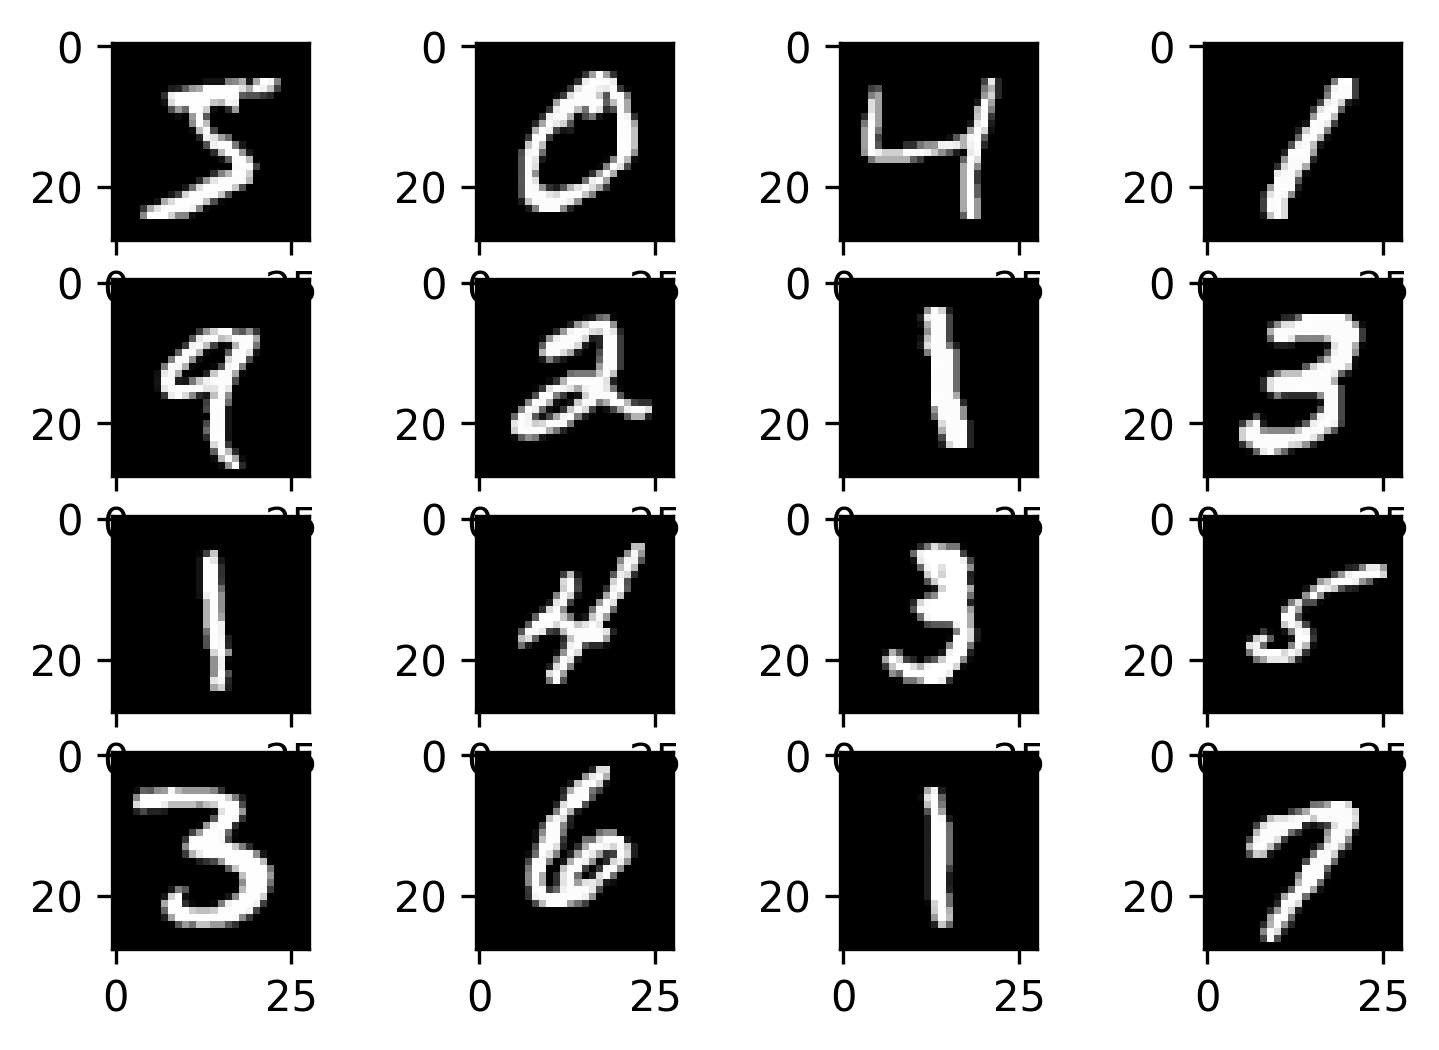

In [ ]:
# load dataset - this is a different version of MNIST compared to sklearn
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(16):
	# define subplot
	plt.subplot(4,4,i+1)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

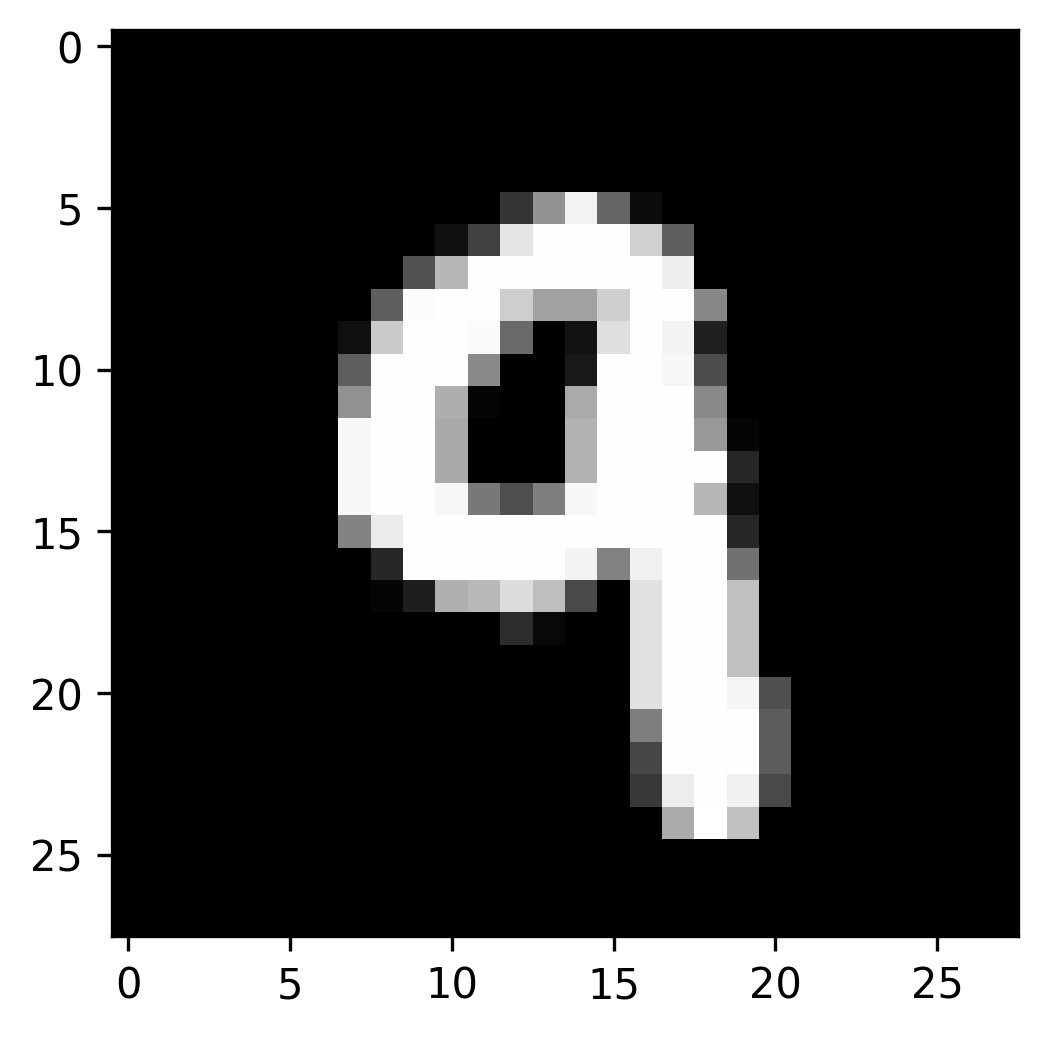

In [ ]:
plt.imshow(trainX[1984], cmap=plt.get_cmap('gray'))

In [ ]:
ytrain = to_categorical(trainy)
ytest = to_categorical(testy)

In [ ]:
ytrain.shape

(60000, 10)

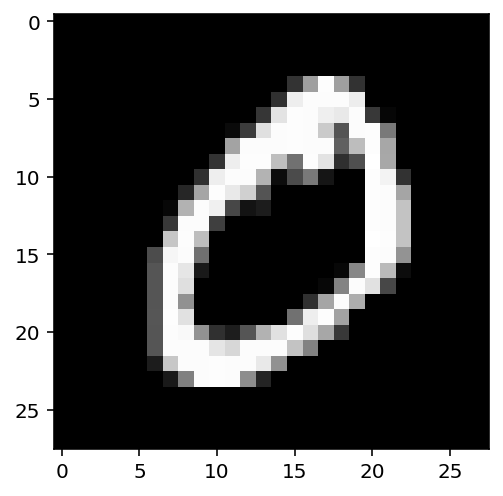

In [ ]:
plt.imshow(trainX[1],cmap=plt.get_cmap('gray'))

In [ ]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))

In [ ]:
trainX.shape

(60000, 28, 28)

In [ ]:
#(trainX, trainy), (testX, testy) = mnist.load_data()

In [ ]:
#tocategorical = OneHotEncoder()

In [ ]:
#ytrain = tocategorical.fit_transform(trainy.reshape(-1,1))

In [ ]:
#print(ytrain[125])

  (0, 8)	1.0


In [ ]:
#ytrain = to_categorical(trainy)

In [ ]:
# inspect the output
#ytrain[125]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
# load dataset
(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

In [ ]:
# one hot encode target values
trainY = to_categorical(trainy)
testY = to_categorical(testy)

In [ ]:
trainY[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

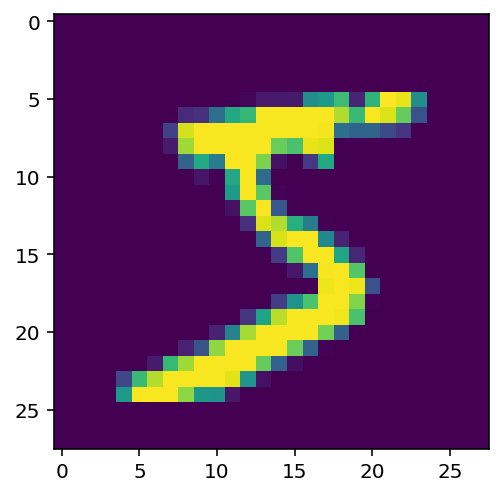

In [ ]:
plt.imshow(trainX[0])

In [ ]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# This is the Design of the Convolutional Neural Network model
def define_model():
	model = Sequential()
	# in the beginning we make convolutions (useful distortions)
	model.add(Conv2D(64, (3,3),
										kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D(pool_size=(4,4)))
	model.add(Conv2D(64,(3,3)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	# here we have the layers of neurons that helps with the actual classification problem
	model.add(Dense(150, activation='relu', kernel_initializer='he_uniform'))
	# the following is the output layer
	model.add(Dense(10, activation='sigmoid'))
	# compile model
	#opt = SGD(lr=0.01, momentum=0.9)
	opt = Adam(learning_rate=0.01)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=10):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1234)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX,trainy):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=25, batch_size=150, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
		plt.tight_layout(pad=3.0)
	plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()
 
# run the test harness for evaluating a model
def run_everything():
	vals= []
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	vals.append(scores)
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
	print('The overall accuracy is :'+str(np.mean(vals)))
 

> 98.567
> 98.500
> 98.350
> 98.550
> 98.567
> 98.717
> 98.450
> 98.783
> 98.733
> 98.250


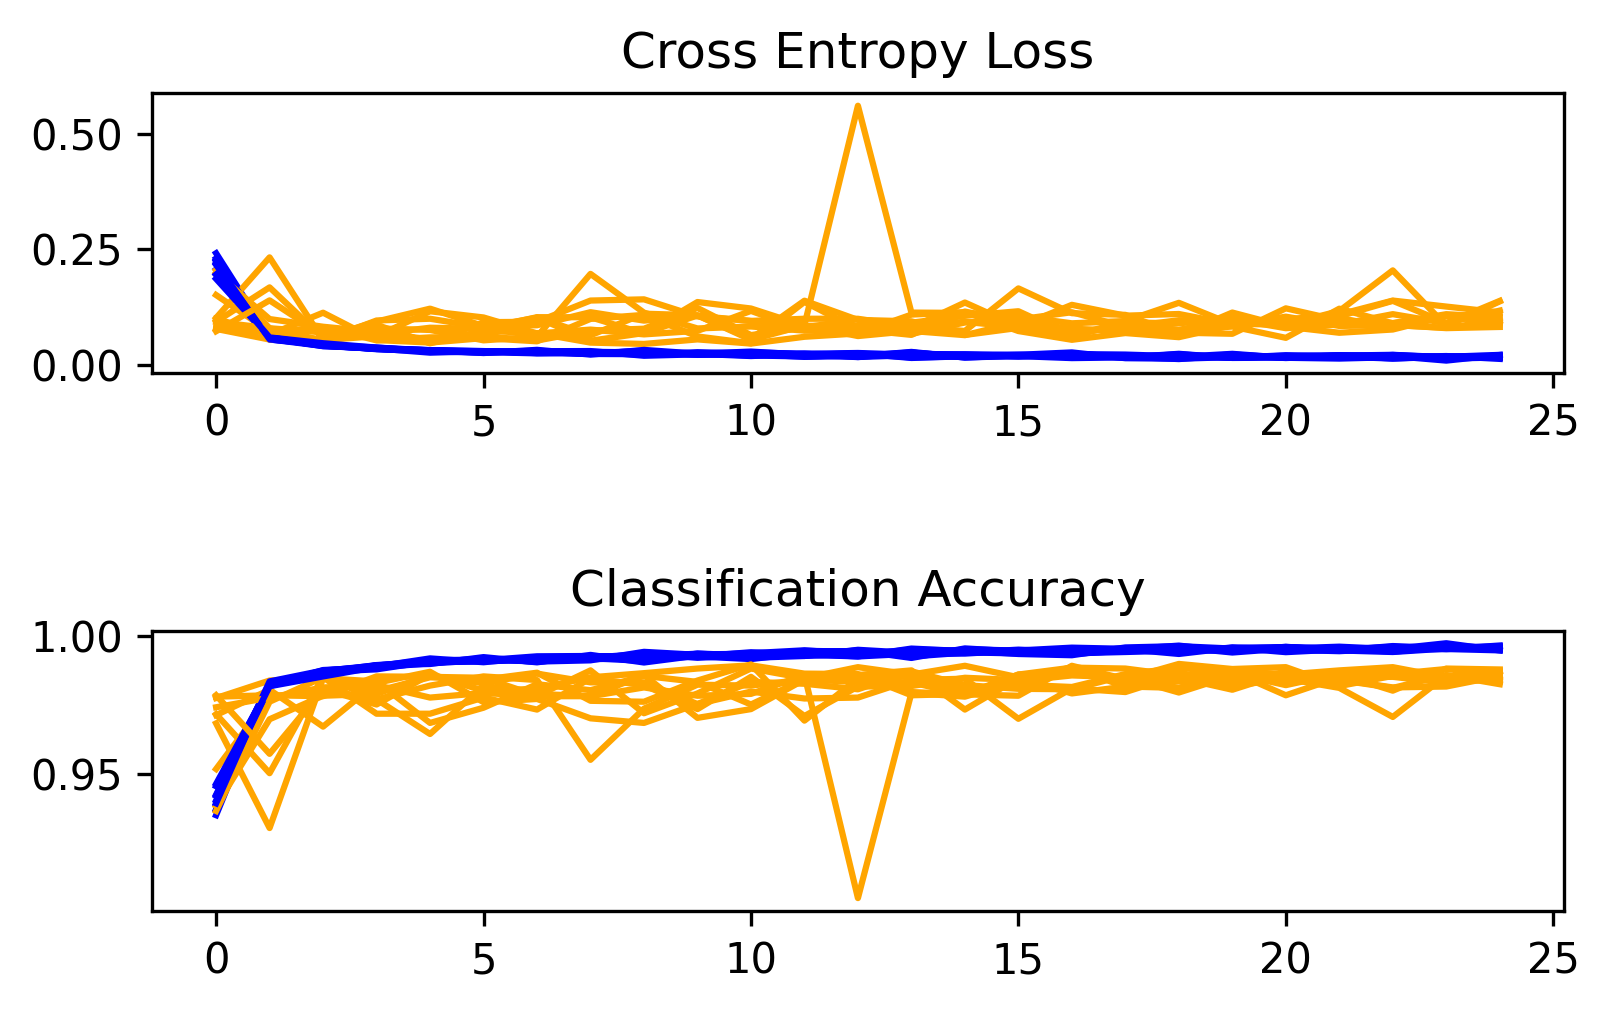

Accuracy: mean=98.547 std=0.161, n=10


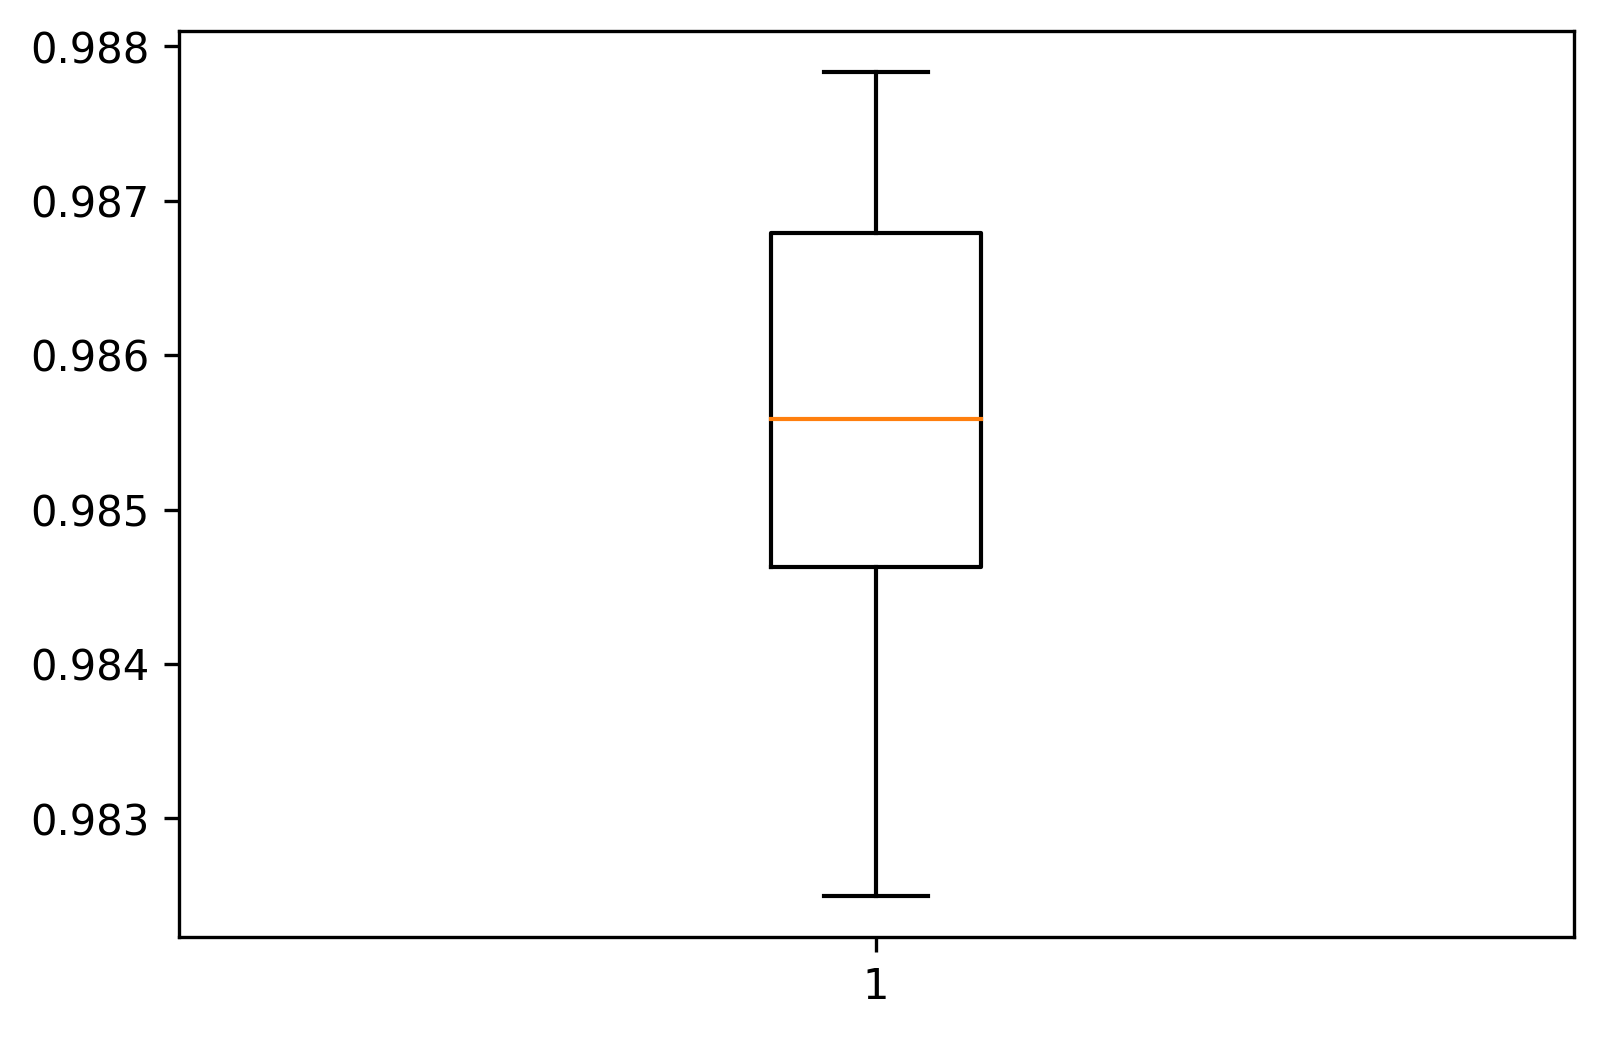

The overall accuracy is :0.9854666709899902


In [ ]:
run_everything()

## Improving Accuracy on the MNIST data with CNN's 

In [ ]:


# what we need to design the CNN
# from tensorflow.keras.layers import Dense, Activation
# from keras.layers import LeakyReLU, ReLU
# from keras.layers import Dropout

 
# load train and test dataset
# def load_dataset():
# 	# load dataset
# 	(trainX, trainY), (testX, testY) = mnist.load_data()
# 	# reshape dataset to have a single channel
# 	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
# 	testX = testX.reshape((testX.shape[0], 28, 28, 1))
# 	# one hot encode target values
# 	trainY = to_categorical(trainY)
# 	testY = to_categorical(testY)
# 	return trainX, trainY, testX, testY
 
# scale pixels
# def prep_pixels(train, test):
# 	# convert from integers to floats
# 	train_norm = train.astype('float32')
# 	test_norm = test.astype('float32')
# 	# normalize to range 0-1
# 	train_norm = train_norm / 255.0
# 	test_norm = test_norm / 255.0
# 	# return normalized images
# 	return train_norm, test_norm
 
# This is the Design of the Convolutional Neural Network model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),input_shape=(28, 28, 1)))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2))) # for downsizing the info from the features a bit
  model.add(Dropout(0.25)) # to prevent having dead neurons
  model.add(Conv2D(64, kernel_size=(3, 3)))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(200))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(10, activation='softmax'))
  opt = Adam(learning_rate=0.002)
  model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
  return model

 
# evaluate a model using k-fold cross-validation
# def evaluate_model(dataX, dataY, n_folds=10):
# 	scores, histories = list(), list()
# 	# prepare cross validation
# 	kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1234)
# 	# enumerate splits
# 	for train_ix, test_ix in kfold.split(dataX,trainy):
# 		# define model
# 		model = define_model()
# 		# select rows for train and test
# 		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
# 		# fit model
# 		history = model.fit(trainX, trainY, epochs=25, batch_size=100, validation_data=(testX, testY), verbose=0)
# 		# evaluate model
# 		_, acc = model.evaluate(testX, testY, verbose=0)
# 		print('> %.3f' % (acc * 100.0))
# 		# stores scores
# 		scores.append(acc)
# 		histories.append(history)
# 	return scores, histories
 


In [ ]:
# plot diagnostic learning curves
# def summarize_diagnostics(histories):
# 	for i in range(len(histories)):
# 		# plot loss
# 		plt.subplot(2, 1, 1)
# 		plt.title('Cross Entropy Loss')
# 		plt.plot(histories[i].history['loss'], color='blue', label='train')
# 		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
# 		# plot accuracy
# 		plt.subplot(2, 1, 2)
# 		plt.title('Classification Accuracy')
# 		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
# 		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
# 		plt.tight_layout(pad=3.0)
# 	plt.show()
 
# # summarize model performance
# def summarize_performance(scores):
# 	# print summary
# 	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
# 	# box and whisker plots of results
# 	plt.boxplot(scores)
# 	plt.show()
 
# run the test harness for evaluating a model
def run_everything_again():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
 

> 99.500
> 99.200
> 98.883
> 99.000
> 99.250
> 99.183
> 99.317
> 99.350
> 99.083
> 99.017


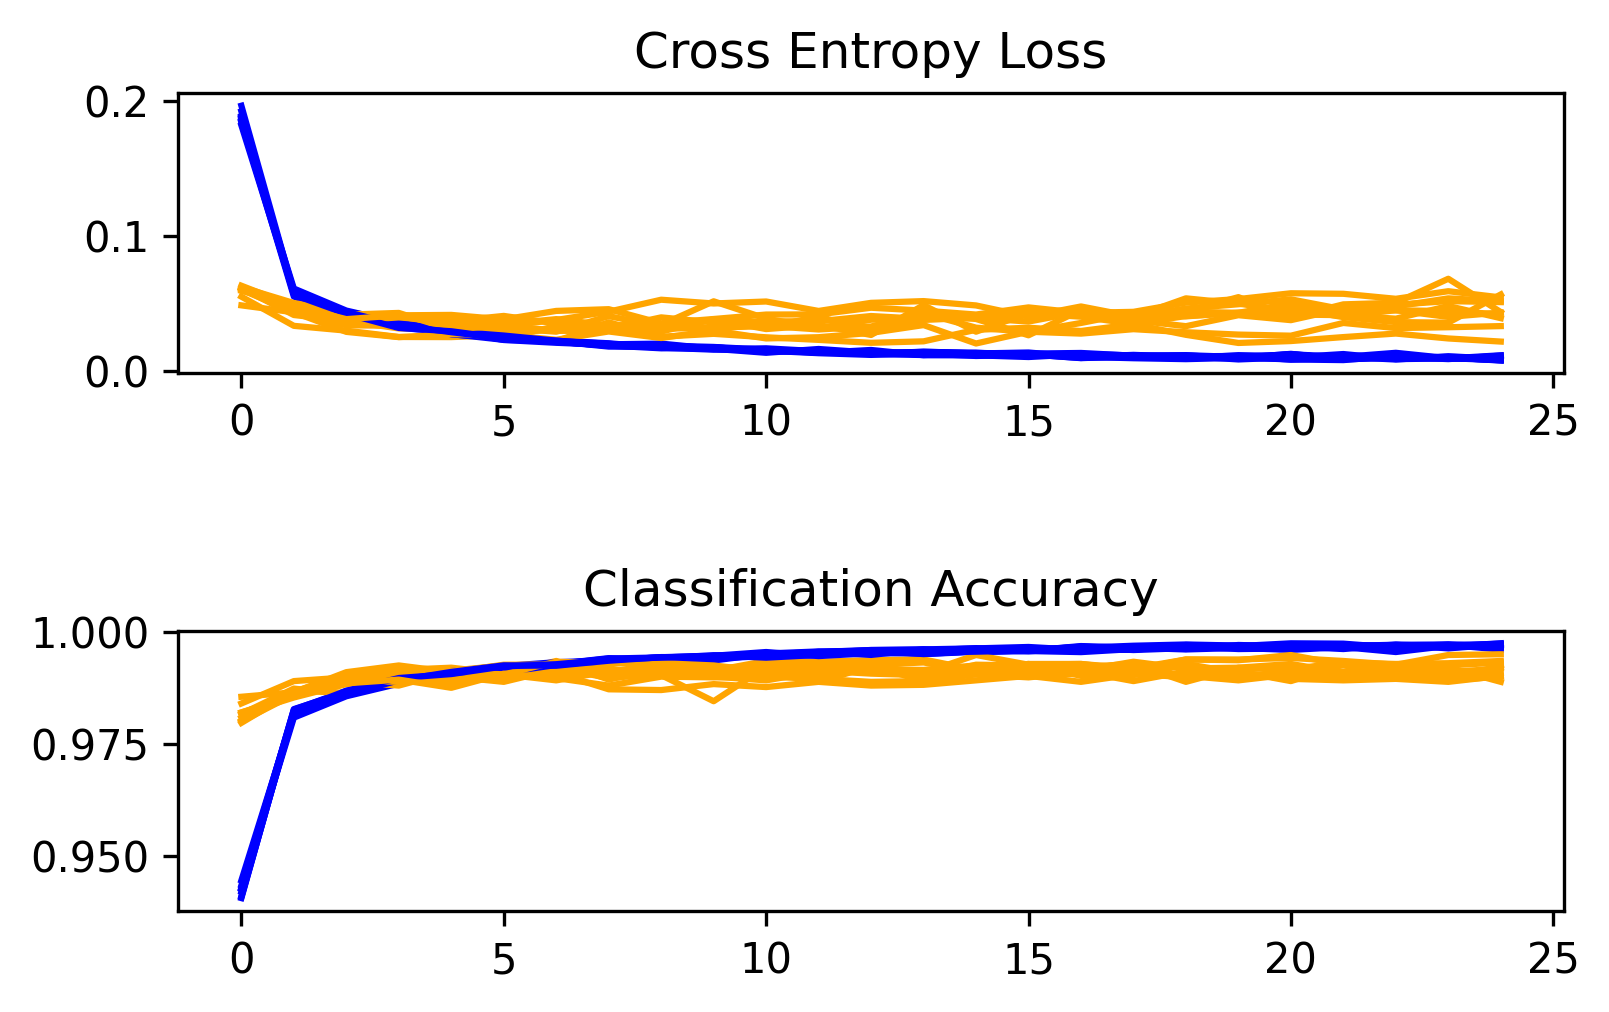

Accuracy: mean=99.178 std=0.177, n=10


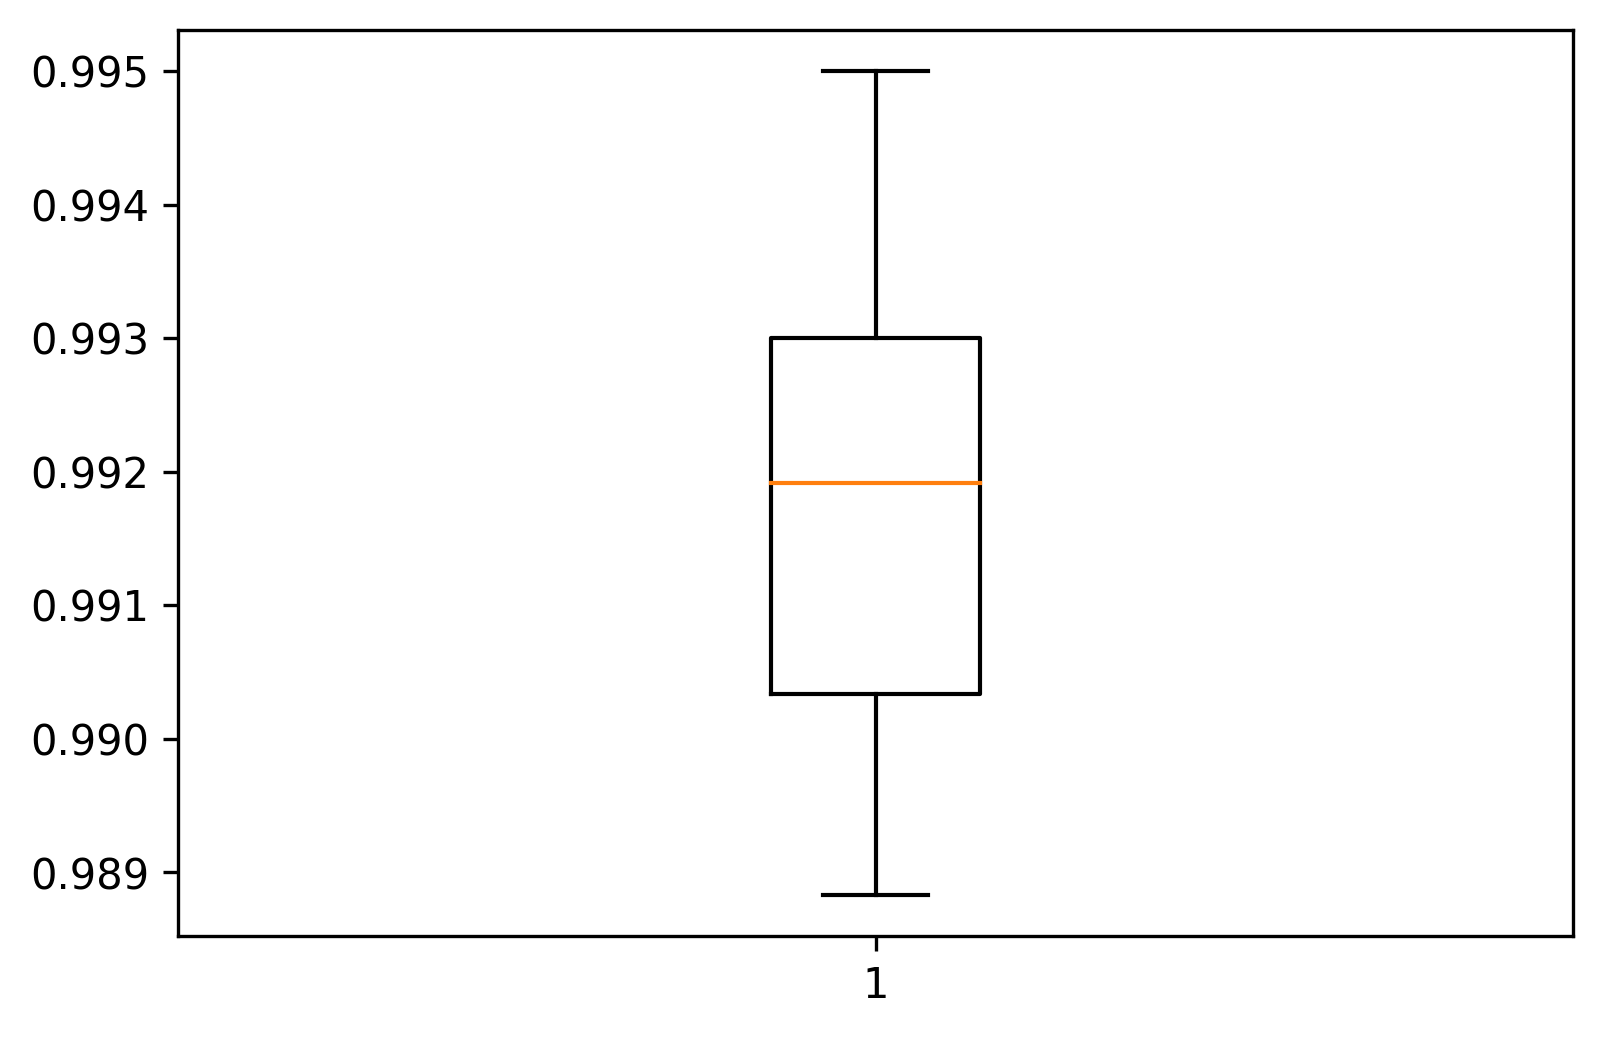

In [ ]:
run_everything_again()

# Another Example - Cifar10 Data Set

### Interesting read: AlexNet - Cifar10
https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

In [ ]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))
    
    return image,label

In [ ]:
batch_size = 64
num_classes = 10
epochs = 150 # you can change this number depending the accuracy obtained after a certain number of epochs
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

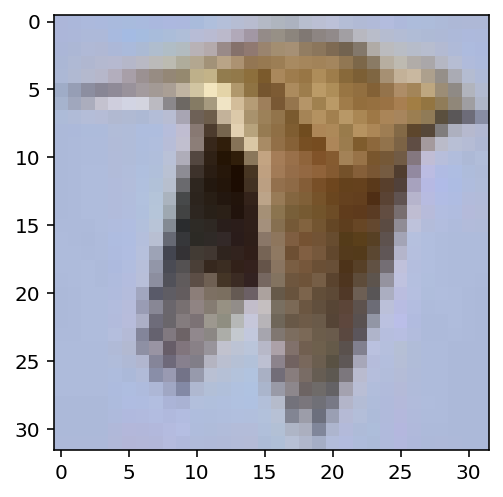

In [ ]:
plt.imshow(x_train[123])
#plt.imsave('data/object/image.png',x_train[123])

In [ ]:
class_names[np.argmax(y_train[123])]

'bird'

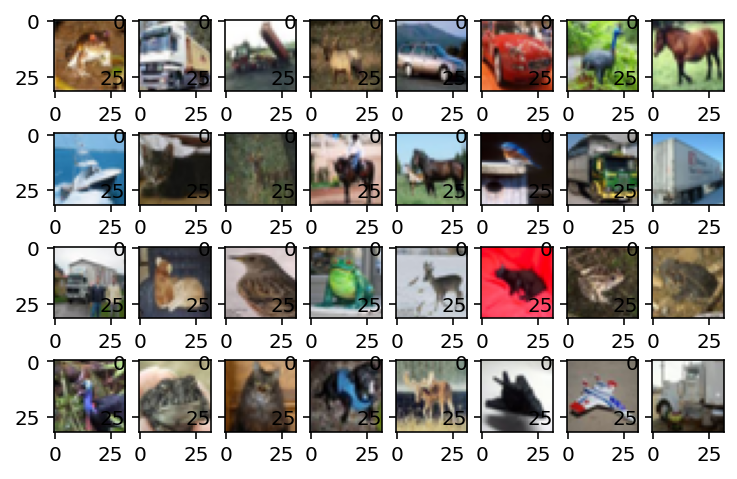

In [ ]:
for i in range(32):
	# define subplot
	plt.subplot(4,8,i+1)
	# plot raw pixel data
	plt.imshow(x_train[i])
# show the figure
plt.show()

In [ ]:
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


Here to visualize the effect of data augmentation you can create the following folder structure:

data
  - bird (or name of the animal/object)
      - (here you save your image in .png format)


output

In [ ]:
pwd

'/content'

In [ ]:
dir_It = aug.flow_from_directory(
    "data/",
    batch_size=1,
    save_to_dir="output/",
    save_prefix="",
    save_format='png',
)

Found 1 images belonging to 2 classes.


(1, 256, 256, 3)


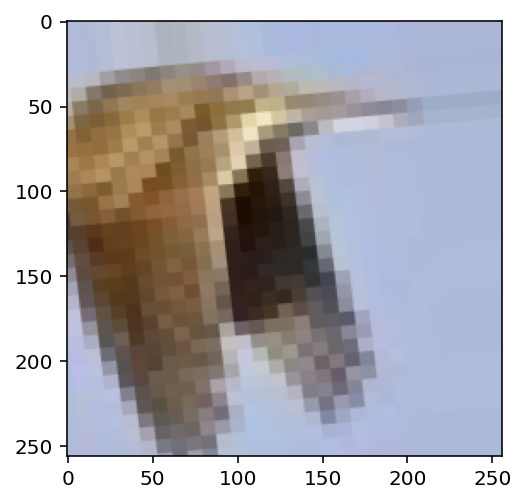

(1, 256, 256, 3)


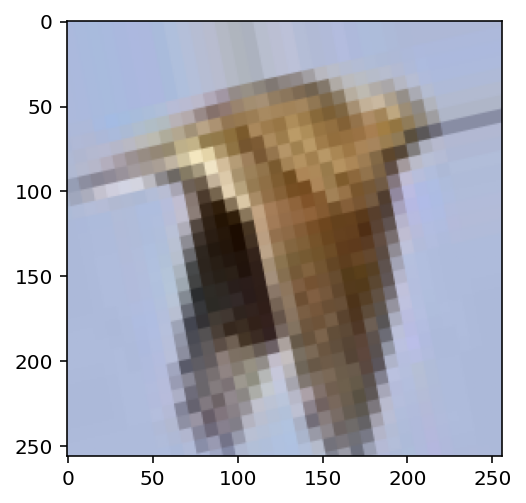

(1, 256, 256, 3)


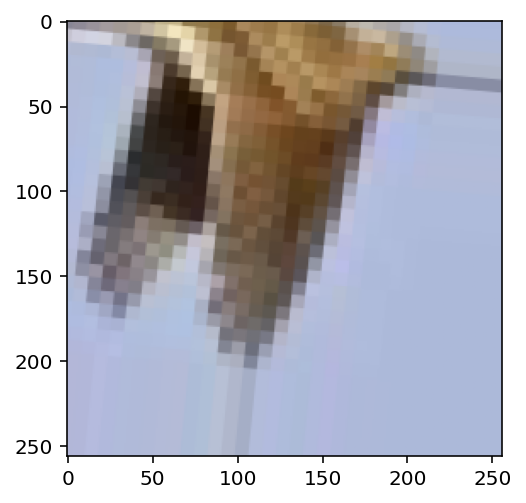

(1, 256, 256, 3)


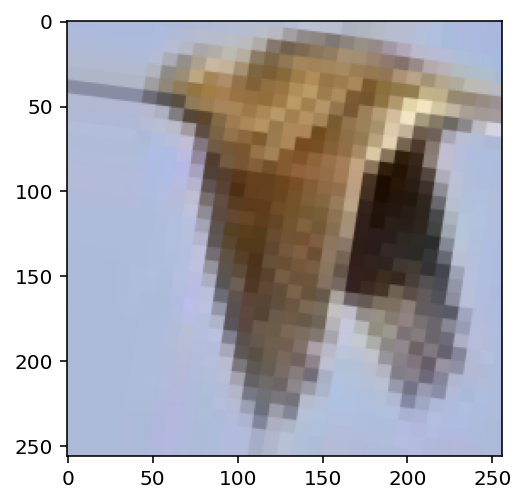

(1, 256, 256, 3)


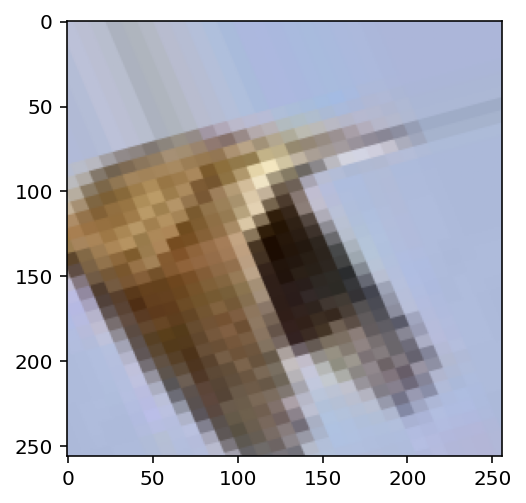

(1, 256, 256, 3)


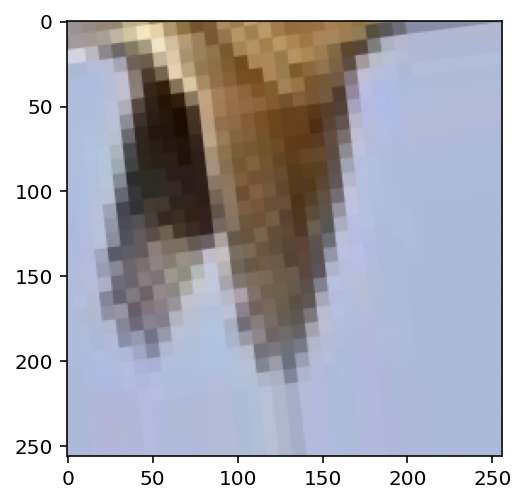

(1, 256, 256, 3)


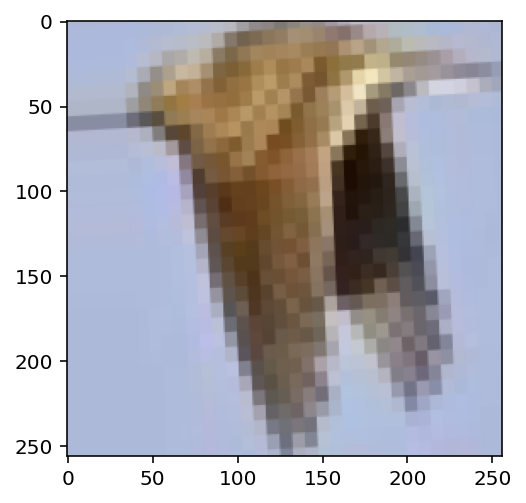

(1, 256, 256, 3)


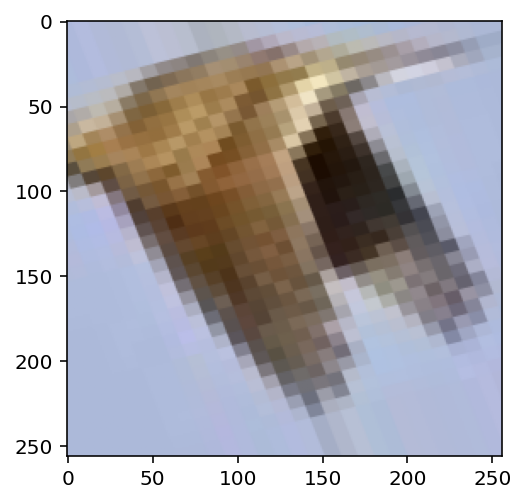

(1, 256, 256, 3)


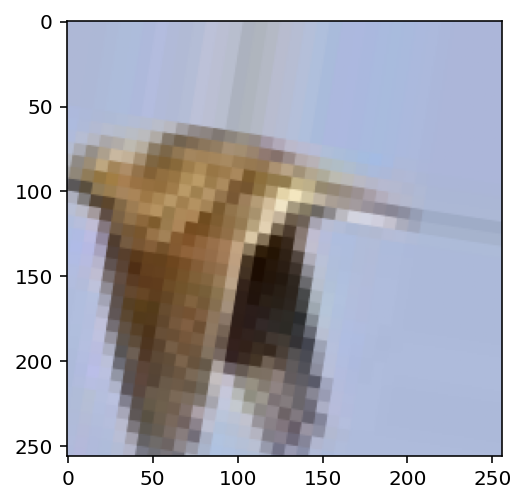

(1, 256, 256, 3)


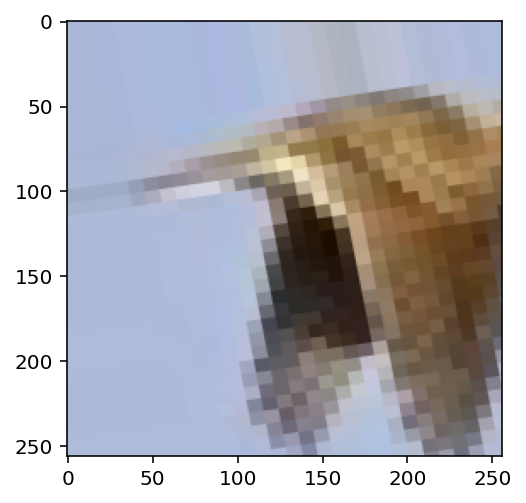

(1, 256, 256, 3)


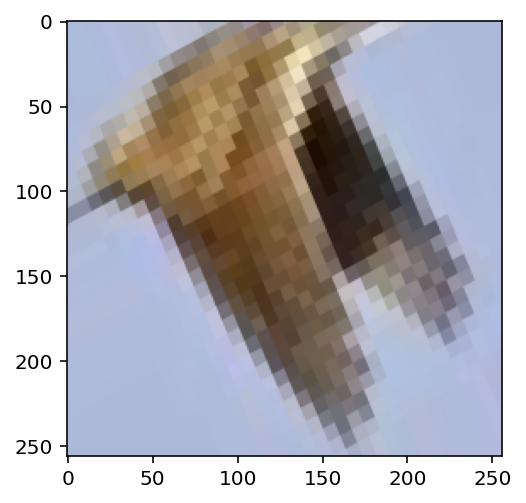

(1, 256, 256, 3)


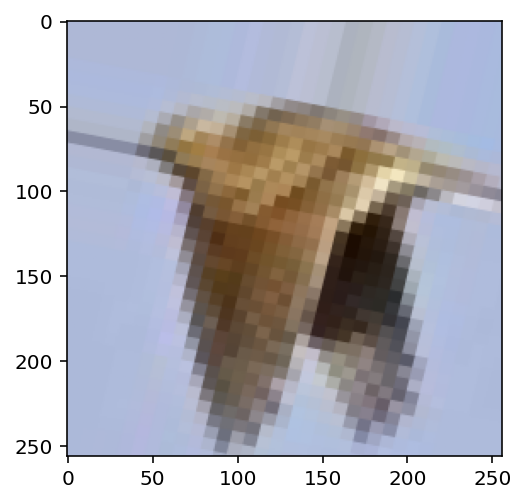

In [ ]:
for _ in range(12):
    img, label = dir_It.next()
    print(img.shape) 
    plt.imshow(img[0]/255)
    plt.show()

In [ ]:
data_augmentation = False

In [ ]:
train_ds_size=x_train.shape[0]
test_ds_size=x_test.shape[0]
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)

Train size: 50000
Test size: 10000


In [ ]:
train_ds=tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_ds=tf.data.Dataset.from_tensor_slices((x_test,y_test))

In [ ]:
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )

In [ ]:
model = Sequential()
model.add(Conv2D(filters=128,kernel_size=(11, 11), padding='same',input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())


model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))

# initiate optimizer
opt = SGD(learning_rate=0.001)

# Let's train the model using the chosen optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-05,  # epsilon for ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.1,  # set range for random shear
        zoom_range=0.1,  # set range for random zoom
        channel_shift_range=0.1,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.1,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.2)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit(datagen.flow(x_train, y_train,
              batch_size=batch_size),
              epochs=epochs,
              validation_data=(x_test, y_test),
              workers=8)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Epoch 1/150
782/782 [==============================] - 62s 76ms/step - loss: 2.1285 - accuracy: 0.2401 - val_loss: 1.8369 - val_accuracy: 0.3393
Epoch 2/150
782/782 [==============================] - 58s 74ms/step - loss: 1.8975 - accuracy: 0.3079 - val_loss: 1.6391 - val_accuracy: 0.4120
Epoch 3/150
782/782 [==============================] - 58s 74ms/step - loss: 1.8105 - accuracy: 0.3431 - val_loss: 1.5970 - val_accuracy: 0.4291
Epoch 4/150
782/782 [==============================] - 59s 74ms/step - loss: 1.7528 - accuracy: 0.3613 - val_loss: 1.5056 - val_accuracy: 0.4632
Epoch 5/150
782/782 [==============================] - 57s 73ms/step - loss: 1.7166 - accuracy: 0.3785 - val_loss: 1.4966 - val_accuracy: 0.4597
Epoch 6/150
782/782 [==============================] - 59s 75ms/step - loss: 1.6773 - accuracy: 0.3918 - val_loss: 1.5737 - val_accuracy: 0.4294
Epoch 7/150
782/782 [==============================] - 59s 74ms/step - loss: 1.6494 - accuracy:

<BatchDataset element_spec=(TensorSpec(shape=(32, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 10), dtype=tf.float32, name=None))>